# Roads and Cables

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/roads_and_cables.ipynb) (requires google account)


In [1]:
%%capture
# Install Topfarm if needed
try:
    import topfarm
except ModuleNotFoundError:
    !pip install topfarm

In colab, use the "inline" backend

In [2]:
# non-updating, inline plots
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# ...or updating plots in new window
#%matplotlib qt

Let's import a few classes

In [3]:
import numpy as np
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm import TopFarmGroup, TopFarmProblem
from topfarm.easy_drivers import EasyRandomSearchDriver, EasyScipyOptimizeDriver
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.cost_models.electrical.simple_msp import ElNetLength, ElNetCost, XYCablePlotComp
from topfarm.cost_models.utils.spanning_tree import mst

from py_wake.site import UniformWeibullSite
from py_wake.site.shear import PowerShear

import matplotlib.pylab as plt



In [4]:
def get_site():
    f = [0.035972, 0.039487, 0.051674, 0.070002, 0.083645, 0.064348,
            0.086432, 0.117705, 0.151576, 0.147379, 0.10012, 0.05166]
    A = [9.176929, 9.782334, 9.531809, 9.909545, 10.04269, 9.593921,
        9.584007, 10.51499, 11.39895, 11.68746, 11.63732, 10.08803]
    k = [2.392578, 2.447266, 2.412109, 2.591797, 2.755859, 2.595703,
        2.583984, 2.548828, 2.470703, 2.607422, 2.626953, 2.326172]
    ti = 0.001
    h_ref = 100
    alpha = .1
    site = UniformWeibullSite(f, A, k, ti, shear=PowerShear(h_ref=h_ref, alpha=alpha))
    spacing = 2000
    N = 5
    theta = 76 # deg
    dx = np.tan(np.radians(theta))
    x = np.array([np.linspace(0,(N-1)*spacing,N)+i*spacing/dx for i in range(N)])
    y = np.array(np.array([N*[i*spacing] for i in range(N)]))
    initial_positions = np.column_stack((x.ravel(),y.ravel()))
    eps = 2000
    delta = 5
    site.boundary = np.array([(0-delta, 0-delta),
                        ((N-1)*spacing+eps, 0-delta),
                        ((N-1)*spacing*(1+1/dx)+eps*(1+np.cos(np.radians(theta))), (N-1)*spacing+eps*np.sin(np.radians(theta))-delta),
                        ((N-1)*spacing/dx+eps*np.cos(np.radians(theta)), (N-1)*spacing+eps*np.sin(np.radians(theta)))])
    site.initial_position = initial_positions
    return site

### Setting up the site to optimize
We will use the IEA-37 site, using the DTU 10MW reference turbine

In [5]:
from py_wake.examples.data.dtu10mw import DTU10MW

site = get_site()
n_wt = len(site.initial_position)
windTurbines = DTU10MW()
Drotor_vector = [windTurbines.diameter()] * n_wt 
power_rated_vector = [float(windTurbines.power(20)/1000)] * n_wt 
hub_height_vector = [windTurbines.hub_height()] * n_wt 
rated_rpm_array = 12. * np.ones([n_wt])

print('Number of turbines:', n_wt)

Number of turbines: 25


Quickly plotting the site boundary and initial position

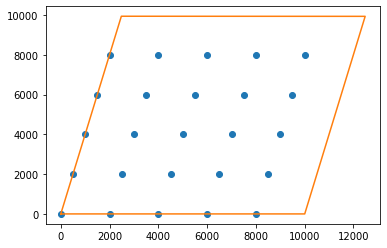

In [6]:
plt.plot(site.initial_position[:,0], site.initial_position[:,1], 'o')
ind = list(range(len(site.boundary))) + [0]
pt = plt.plot(site.boundary[ind,0], site.boundary[ind,1], '-')

### Setting up the AEP calculator
- Using the Gaussian wake model from Bastankhah & PortÃ© Agel
- Based on 16 wind direction to speed things up (not critical here because we will be using the RandomSearch algorithm)

In [7]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.aep_calculator import AEPCalculator

## We use the Gaussian wake model
wake_model = IEA37SimpleBastankhahGaussian(site, windTurbines)

## The AEP is calculated using n_wd wind directions
n_wd = 16
wind_directions = np.linspace(0., 360., n_wd, endpoint=False)

def aep_func(x, y, **kwargs):
    """A simple function that takes as input the x,y position of the turbines and return the AEP per turbine"""
    return wake_model(x=x, y=y, wd=wind_directions).aep().sum('wd').sum('ws').values*10**6

In [8]:
aep_func(site.initial_position[:,0], site.initial_position[:,1])

array([48951465.12270607, 48201050.47235204, 48074496.39187684,
       48091563.8068087 , 48445617.28814225, 48836394.16658428,
       48071863.46810313, 47814362.6852063 , 47837628.23097131,
       48208400.31612337, 48842864.11110101, 48084779.74156096,
       47877873.48662869, 47893042.54928257, 48272147.94935018,
       48739999.86619873, 47999291.34685232, 47768651.4696867 ,
       47854282.08031107, 48249587.04727601, 48779201.65440664,
       48053197.5070104 , 47829089.74539277, 47887992.1373282 ,
       48326743.1406377 ])

### Setting up the NREL IRR cost model
Based on the 2006 NREL report

In [9]:
from topfarm.cost_models.economic_models.turbine_cost import economic_evaluation as EE_NREL

def irr_nrel(aep, electrical_connection_cost, **kwargs):
    return EE_NREL(Drotor_vector, power_rated_vector, hub_height_vector, aep, electrical_connection_cost).calculate_irr()


### Setting up the DTU IRR cost model
Based on Witold's recent work

In [10]:
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation as EE_DTU

distance_from_shore = 10.0 # [km]
energy_price = 0.2 / 7.4 # [DKK/kWh] / [DKK/EUR] -> [EUR/kWh]
project_duration = 20 # [years]
water_depth_array = 20 * np.ones([n_wt])
Power_rated_array = np.array(power_rated_vector)/1.0E3 # [MW]

ee_dtu = EE_DTU(distance_from_shore, energy_price, project_duration)


def irr_dtu(aep, electrical_connection_cost, **kwargs):
    ee_dtu.calculate_irr(
                    rated_rpm_array, 
                    Drotor_vector, 
                    Power_rated_array,
                    hub_height_vector, 
                    water_depth_array, 
                    aep, 
                    electrical_connection_cost)
    return ee_dtu.IRR

### Setting up the Topfarm problem

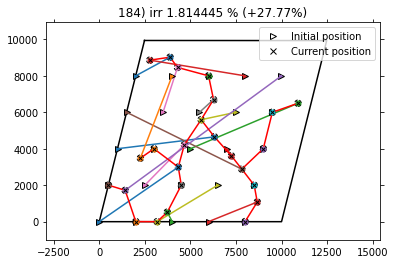

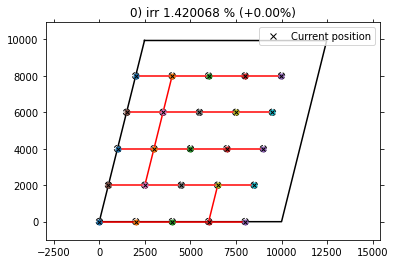

In [11]:
## Some user options
#@markdown Which IRR Cost model to use
IRR_COST = 'DTU' #@param ["DTU", "NREL"]

#@markdown Minimum spacing between the turbines
min_spacing = 2 #@param {type:"slider", min:2, max:10, step:1}

#@markdown Minimum spacing between the turbines
cable_cost_per_meter = 750. #@param {type:"slider", min:0, max:10000, step:1}

## Electrical grid cable components (Minimum spanning tree from Topfarm report 2010)
elnetlength = ElNetLength(n_wt=n_wt)
elnetcost = ElNetCost(n_wt=n_wt, output_key='electrical_connection_cost', cost_per_meter=cable_cost_per_meter)

# The Topfarm IRR cost model components
irr_dtu_comp = CostModelComponent(input_keys=[('aep',np.zeros(n_wt)), ('electrical_connection_cost', 0.0)],   n_wt=n_wt, 
                                  cost_function=irr_dtu, output_key="irr", output_unit="%",   objective=True, 
                                  income_model=True)
irr_nrel_comp = CostModelComponent(input_keys=[('aep', np.zeros(n_wt)), ('electrical_connection_cost', 0.0)],   n_wt=n_wt, 
                                   cost_function=irr_nrel, output_key="irr", output_unit="%",   objective=True, 
                                   income_model=True)
irr_cost_models = {'DTU': irr_dtu_comp, 'NREL': irr_nrel_comp}


## The Topfarm AEP component, returns an array of AEP per turbine
aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func, 
                              output_key="aep", output_unit="GWh", objective=False, output_val=np.zeros(n_wt))

## Plotting component
plot_comp = XYCablePlotComp(memory=0, plot_improvements_only=False, plot_initial=False)


## The group containing all the components
group = TopFarmGroup([aep_comp, elnetlength, elnetcost, irr_cost_models[IRR_COST]])

problem = TopFarmProblem(
        design_vars={'x':site.initial_position[:,0],
                     'y':site.initial_position[:,1]},
        cost_comp=group,
        driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(), max_iter=100),
        constraints=[SpacingConstraint(min_spacing * windTurbines.diameter(0)),
                     XYBoundaryConstraint(site.boundary)],
        expected_cost=1.0,
        plot_comp=plot_comp)

cost, state, recorder = problem.optimize()

### Exercises
- Try to see what is the effect of increasing or decreasing the cost of the cable
- Change between IRR cost model. Ask Witold about the difference between DTU and NREL models